In [156]:
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
import importlib

In [157]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2018/attention_config_spatial_T2m_U10m_201980.pth"

In [158]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH = Path('.')
# Load mask
with h5py.File(PATH / "data/mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH / "data/test.h5", window=window, flatten=True)

channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 48,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }


Using device: cuda
Spatial Encoding Shape : torch.Size([4, 64, 64])
Channels : 24


In [159]:
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2018/attention_config_spatial_T2m_U10m_201980.pth, trained until epoch 80


/tmp/ipykernel_1762240/3784321478.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [160]:
for batch, dic in testloader:
    t = torch.rand(batch.shape[0], dtype=batch.dtype)
    t[0] = 0.8
    t[1] = 0.9
    t[2] = 1
    c = dic["context"]
    c = c.to(device)
    batch = batch.to(device)
    t = t.to(device)
    x_t = vpsde.forward(batch, t , train=False)
    x_0 = vpsde.denoise(x_t,t,c)
    print(vpsde.mu(t[:3]))
    print(vpsde.sigma(t[:3]))
    break

tensor([0.1313, 0.0480, 0.0050], device='cuda:0')
tensor([0.9914, 0.9989, 1.0000], device='cuda:0')


<h1> Display Batch </h1>

torch.Size([48, 24, 64, 64])
torch.Size([48, 2, 12, 64, 64])
torch.Size([48, 2, 12, 64, 64])
Input shape: torch.Size([48, 2, 12, 64, 64])
T2m  Mean : 0.711385190486908, Var: 0.20464199781417847
U10m  Mean : -0.7173851132392883, Var: 0.43694713711738586


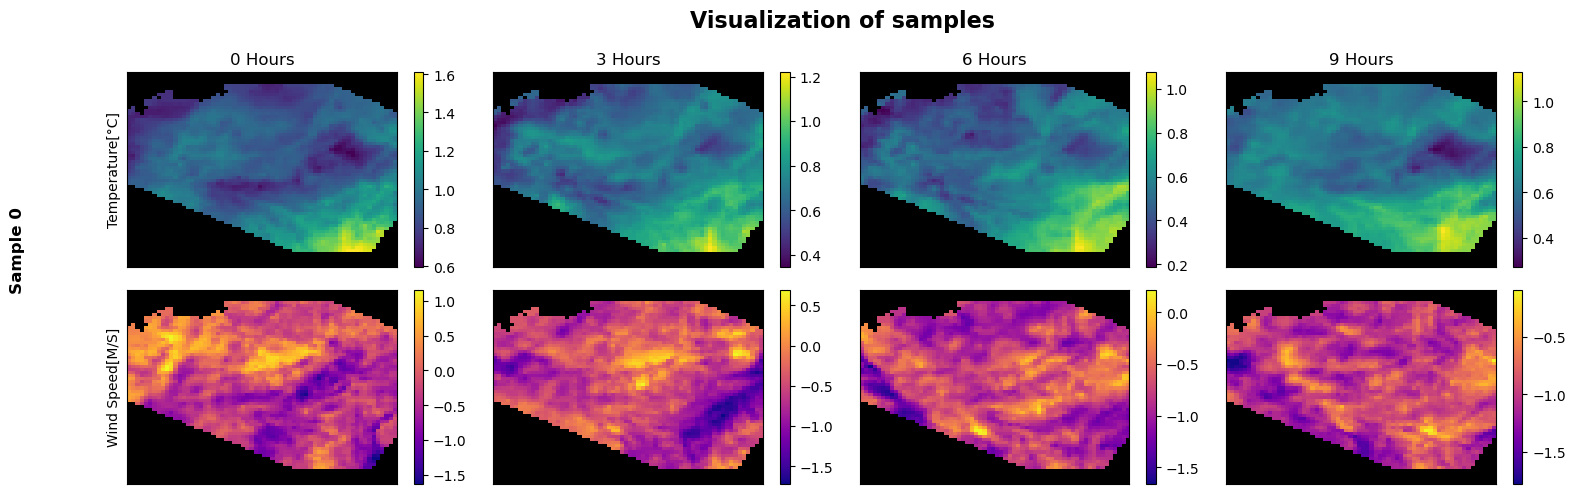

In [161]:
from utils import plot_sample
path_unnorm = PATH / "data/norm_params.h5"
info = {'var_index': ['T2m', 'U10m'], 'channels': 2, 'window': 12}

batch_cpu = batch.detach().cpu()
fig = plot_sample(batch_cpu, info, mask_cpu, samples=1, step=3, unnormalize=False, path_unnorm = path_unnorm)

<h1> Load and Plot Samples</h1>

In [170]:
# Load Samples
c = c.to(torch.float32).to(device)

sample = vpsde.sample(mask,c=c[:10],shape=(10,),steps=64, corrections=2)

100%|███████████████████████████████████████████████████| 64/64 [00:02<00:00, 24.32it/s]


torch.Size([10, 24, 64, 64])
torch.Size([10, 2, 12, 64, 64])
torch.Size([10, 2, 12, 64, 64])
Input shape: torch.Size([10, 2, 12, 64, 64])
T2m  Mean : -3.379042148590088, Var: 1.384450078010559
U10m  Mean : 3.9476206302642822, Var: 1.6704760789871216
T2m  Mean : 12.543190956115723, Var: 2.0055971145629883
U10m  Mean : 8.141897201538086, Var: 2.3353869915008545
T2m  Mean : 1.4049975872039795, Var: 1.5580557584762573
U10m  Mean : 3.7923545837402344, Var: 1.4287889003753662
T2m  Mean : -0.8707067966461182, Var: 1.6323593854904175
U10m  Mean : 6.7325263023376465, Var: 1.8051015138626099
T2m  Mean : 8.67607307434082, Var: 1.447301983833313
U10m  Mean : 7.690912246704102, Var: 1.8669263124465942
T2m  Mean : -7.285632133483887, Var: 2.3481976985931396
U10m  Mean : 5.173000812530518, Var: 1.2916020154953003
T2m  Mean : 14.826276779174805, Var: 2.7123425006866455
U10m  Mean : 7.058136940002441, Var: 1.7546030282974243
T2m  Mean : 2.1102731227874756, Var: 1.4902867078781128
U10m  Mean : 10.628146

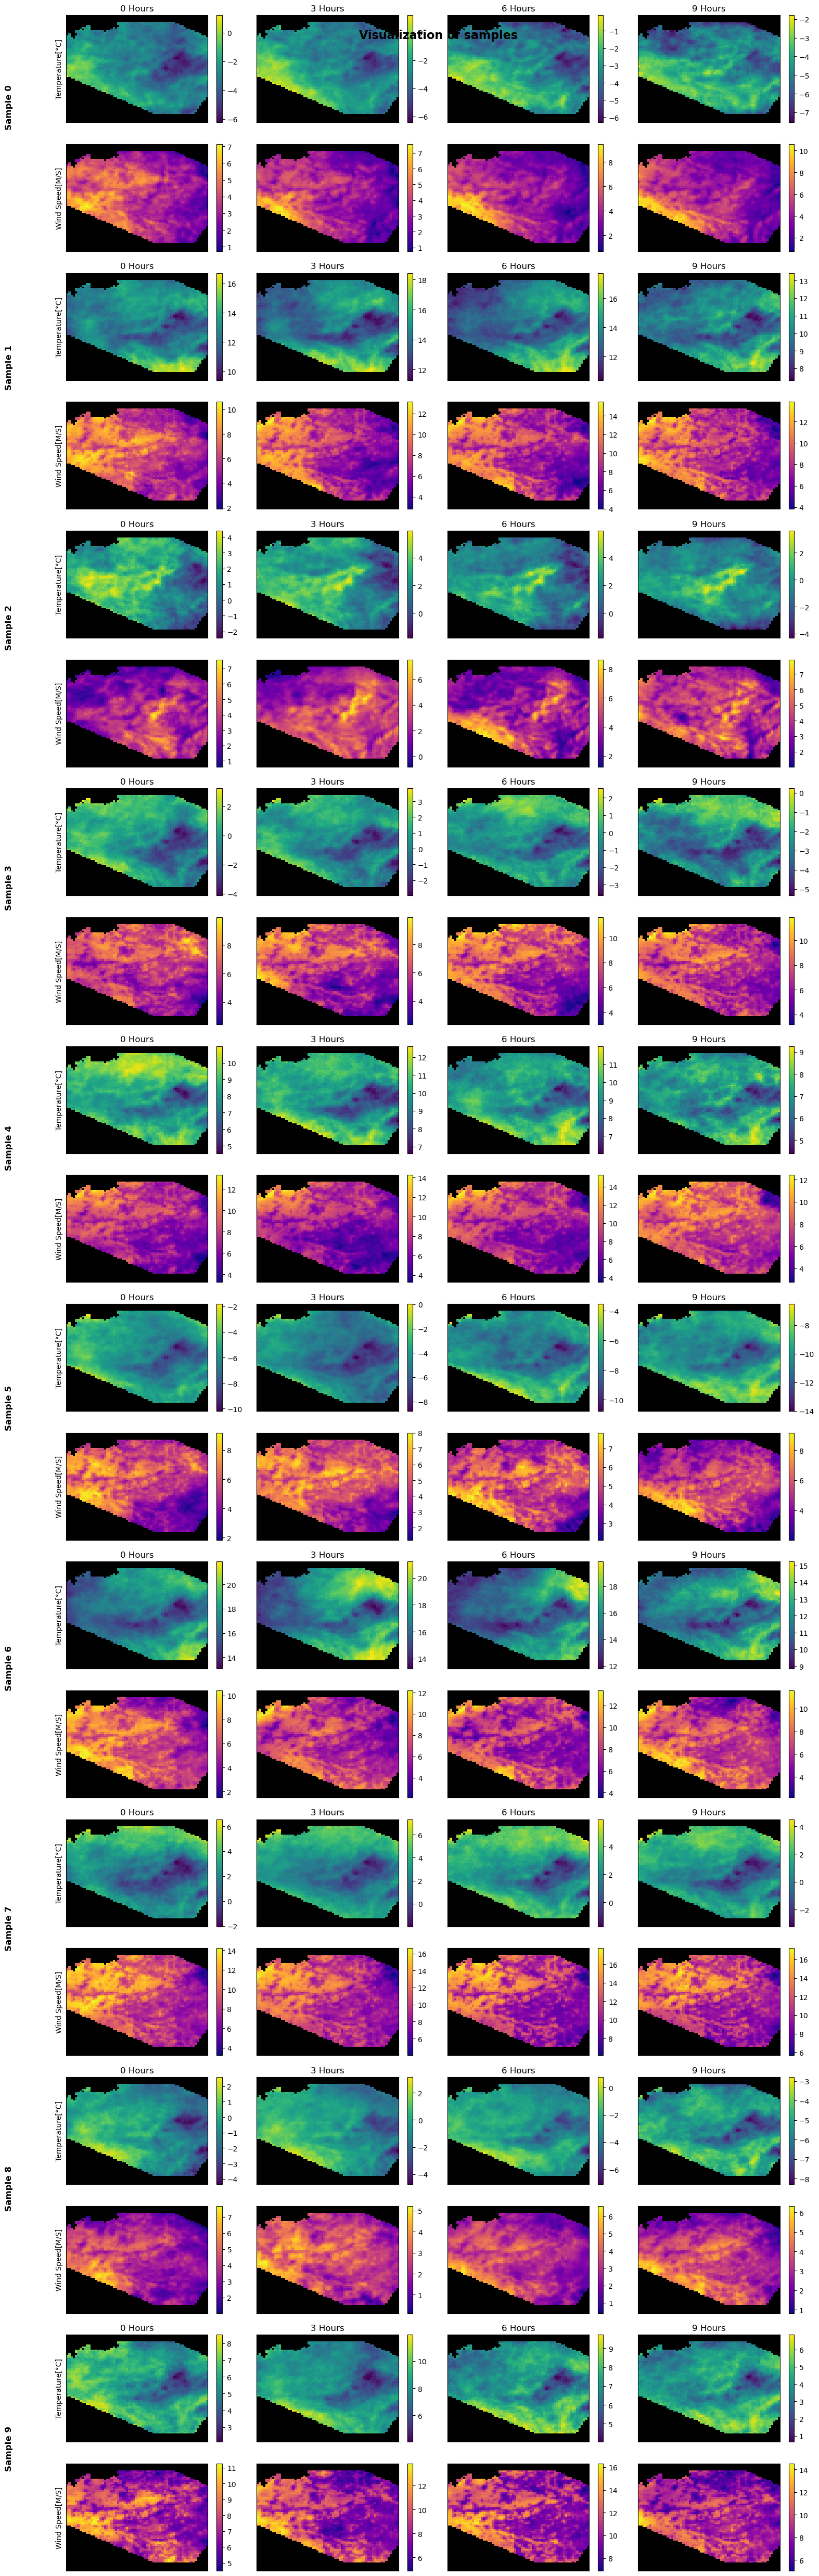

In [172]:
sample_cpu = sample.detach().cpu()
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(sample_cpu,info,mask_cpu,samples=10,step=3, unnormalize=True)

<h1>Plot : Batch, Noised Batch and Unnoising of Noised Batch</h1>

torch.Size([144, 24, 64, 64])
torch.Size([144, 2, 12, 64, 64])
torch.Size([144, 2, 12, 64, 64])
Input shape: torch.Size([144, 2, 12, 64, 64])
T2m  Mean : 16.59514617919922, Var: 1.5085784196853638
U10m  Mean : 2.4894230365753174, Var: 0.9517434239387512
T2m  Mean : 12.030298233032227, Var: 7.343887805938721
U10m  Mean : 3.841477632522583, Var: 2.15027117729187
T2m  Mean : 16.51109504699707, Var: 2.0662171840667725
U10m  Mean : 2.473802089691162, Var: 0.8406439423561096
T2m  Mean : -4.595024585723877, Var: 1.377012014389038
U10m  Mean : 2.4504709243774414, Var: 1.0221316814422607
T2m  Mean : 10.614849090576172, Var: 7.329370021820068
U10m  Mean : 3.9571940898895264, Var: 2.1782615184783936
T2m  Mean : -3.5518174171447754, Var: 4.1432929039001465
U10m  Mean : 2.204411506652832, Var: 1.371269702911377
T2m  Mean : -0.21463964879512787, Var: 1.0062236785888672
U10m  Mean : 1.633573293685913, Var: 0.6994507312774658
T2m  Mean : 11.322724342346191, Var: 7.343594551086426
U10m  Mean : 4.041087

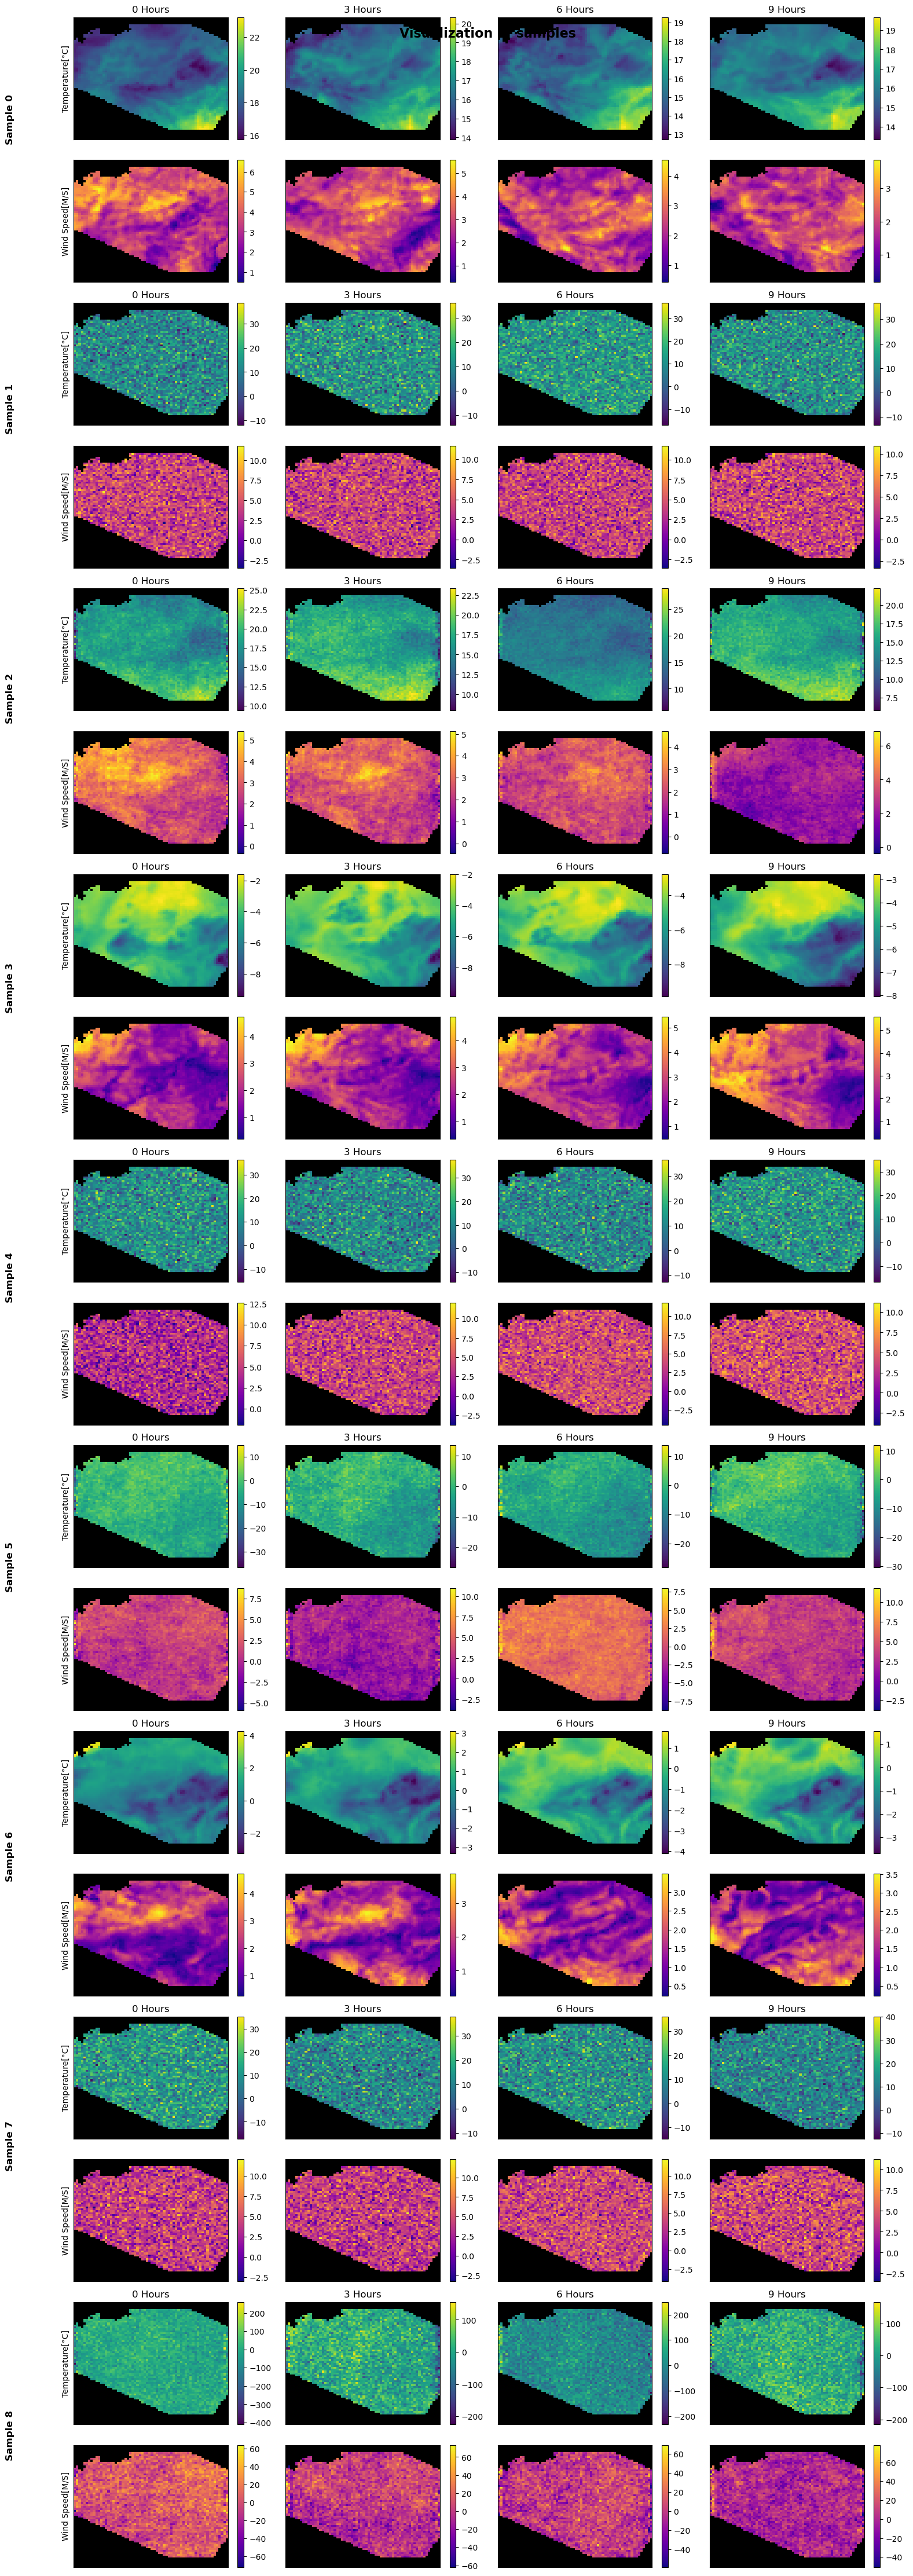

In [173]:
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
new_tensor = torch.stack((batch,x_t,x_0), dim=1).flatten(0,1).detach().cpu()

fig = plot_sample(new_tensor,info,mask_cpu,samples=9,step=3, unnormalize=True)